## 0 | Import packages

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tkinter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from utilities import importFile, openFile, openHDF5file, getLooseRseal
from tkinter.filedialog import askopenfilename, askopenfilenames
from collections import defaultdict
from nptdms import TdmsFile
from scipy import stats
from scipy.signal import find_peaks
print("done!")

done!


## 1 | Use find_peaks() to detect spikes in all sweeps

Now that we can detect spikes and are sure we are not counting noise, we can continue to do the same for all the sweeps of the cell we are analysing. We are going to need (1) be able to plot the histogram of prominences for the detected peaks and (2) be able to ask the user for input so it can set the adequate prominence bracket to detect spikes and not noise. And we need to do this on a sweep by sweep basis.

First of all, we load an example cell to work with:

In [2]:
# Load data for LIAM cell (contains spikes in test_pulse)
channels_data_frame_1, time_1, dt_1, folder_name_1, file_name_1 = importFile(curated_channel = 'Sweeps_Analysis')
print("file imported")

file imported


In [3]:
# Inspect data frame
channels_data_frame_1

,13,14,15,16,17,18,19,20,21,22,...,39,40,41,42,43,44,45,46,47,48
Channel A,"[1.1889297824046958, 1.253328465971537, 1.2533...","[1.2855278078017005, 1.2211291241725364, 1.221...","[1.2855278078017005, 1.2211291241725364, 1.253...","[1.253328465971537, 1.1889297824046958, 1.2533...","[1.2211291241725364, 1.2211291241725364, 1.221...","[1.2211291241725364, 1.2855278078017005, 1.382...","[1.1889297824046958, 1.349926491555527, 1.2211...","[1.2211291241725364, 1.2211291241725364, 1.253...","[1.253328465971537, 1.3821258334791953, 1.2533...","[0.5127436124734345, 0.5127436124734345, 0.480...",...,"[1.1889297824046958, 1.1567304406680132, 1.188...","[1.1567304406680132, 1.1567304406680132, 1.221...","[1.1567304406680132, 1.1889297824046958, 1.253...","[1.1567304406680132, 1.1889297824046958, 1.092...","[0.6737403183549117, 0.6737403183549117, 0.641...","[0.6415409771163951, 0.6737403183549117, 0.641...","[0.6093416359089918, 0.6737403183549117, 0.641...","[0.6415409771163951, 0.5449429535875141, 0.641...","[0.5449429535875141, 0.5127436124734345, 0.512...","[0.5771422947326991, 0.6737403183549117, 0.512..."
Channel B,"[-20.310042374699133, -20.632035761040658, -18...","[-3.8883792610270644, -10.97223403629284, -12....","[-0.6684452226398963, -0.9904386278756757, -5....","[15.431225435651891, 10.923317572881103, 8.347...","[14.143251754340366, 8.025376836201604, 7.7033...","[1.2635152152973421, 2.873482255456038, 1.5855...","[2.873482255456038, 2.873482255456038, 5.77142...","[11.889297824046958, 13.821258334791953, 19.93...","[26.379001928434015, 33.140864060409456, 34.10...","[-23.52997622421571, -21.92000930331773, -25.7...",...,"[-1.9564188417199486, -3.2443924558328088, -3....","[7.3813900092529385, 9.313350493834292, 8.3473...","[10.923317572881103, 5.127436124734345, -0.024...","[11.245310989624853, 12.211291241725363, 16.07...","[0.619528401409027, -4.532366064980151, -2.600...","[-22.242002688114866, -22.242002688114866, -18...","[-19.34406221382072, -21.276022532796944, -16....","[-16.124128324134816, -16.124128324134816, -16...","[-7.752300066135383, -7.430306667415194, -12.5...","[-7.1083132683849986, -9.362267055087196, -7.1..."
Output A,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Output B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

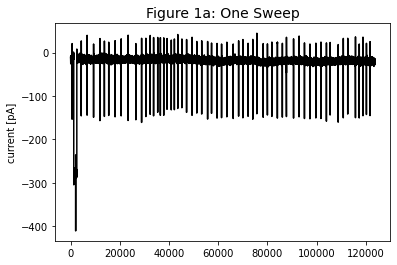

In [4]:
# Extract sweep
sweep_IB_1 = np.array(channels_data_frame_1.at['Channel B', '30'])

# Plot it
%matplotlib inline
# matplotlib tk
plt.plot(sweep_IB_1, 'k')
plt.title('Figure 1a: One Sweep', fontsize = 14)
plt.ylabel('current [pA]')
plt.show()

### 1.1 | Find a way to plot and ask for input within a loop

We can ask for input with the input() function, and convert the value to integer.

In [ ]:
prominence_min = int(input("Enter the min value for the desired prominence"))
prominence_max = int(input("Enter the max value for the desired prominence"))

print(prominence_min)
print(prominence_max)

We next need a way to first show the histogram, and then ask for the user input. The cell below will work as desired if it is run as a script from the command line. Briefly, it will plot a figure, wait for a period of time (or for the user to press a key once the figure has been examined), and then ask for the min and max values of prominence to use to detect peaks. We will build on this backbone to achieve a code that will loop over files in a folder, detect peaks according to a desired prominence, store the peaks and spikes, and proceed to the next cell.

In [ ]:
#this will work if you run it from a script called from the terminal. Right now, it doesn't work as desired in the notebook.
import matplotlib.pyplot as plt
for i in range(10):
    plt.ion()
    plt.figure(figsize = (8, 6), dpi = 100) # Set figure size
    plt.scatter(1, i)
    plt.title(i+1)
    
    plt.pause(0.5) # Alternative to waitforbuttonpress() - does not close the figure and proceeds to input().
    # if plt.waitforbuttonpress(): # if not using pause(), this is needed to render the figure
    #     plt.close()

    prominence_min = int(input("Enter the min value for the desired prominence"))
    prominence_max = int(input("Enter the max value for the desired prominence"))
    print(f'For sweep number {i}, you chose a prominence between {prominence_min} and {prominence_max}')
    
    plt.close() # needed here if plt.pause() is used instead of plt.waitforbuttonpress()

The next cell contains a close reproduction of the code above to work on a notebook. Unfortunately, in the notebook we need to manually click on the editor to switch focus from the figure to the input prompt in order to enter the desired prominence values, so it is a bit slower. In addition, the figure doesn't close after clicking a button, which in this case is a good thing as we can keep examining it until we have entered both prominence values and the code proceeds to the next iteration.

In [ ]:
%matplotlib tk
#%matplotlib inline

for i in range(10):
    plt.figure(figsize = (8, 6), dpi = 100)
    plt.scatter(1, i)
    plt.title(i+1)
    plt.pause(0.5) # Alternative to waitforbuttonpress() - does not close the figure and proceeds to input(), but you can't interact with the figure. 
    # if plt.waitforbuttonpress(): # if not using pause(), this is needed to render the figure
    #     plt.close()
    
    in = int(input("Enter the min value for the desired prominence"))
    prominence_max = int(input("Enter the max value for the desired prominence"))
    print(f'For sweep number {i}, you chose a prominence between {prominence_min} and {prominence_max}')
    
    if
    
    plt.close() # needed here if plt.pause() is used instead of plt.waitforbuttonpress()

### 1.2 | Concatenate all sweeps and run find_peaks

To speed things up a bit, we don't want to loop over sweeps on top of looping over cells. Ideally, we want to run find_peaks on the full recording of a cell, get the histogram, fine-tune the prominence values, and then get the spikes. Later, we will be able to correct for any interval between peaks when calculating the interspike intervals.

For instance, in protocol VC_clear (see below) there was a brief interval between sweeps. This means the ISI between the last spike of one sweep and the first spike of the next won't be accurate, and we may have missed spikes in that short period. For the other protocols this should not be an issue, and we should be able to obtain ISI from the concatenated sweep.

For now, let's make it work. We will correct this later on.

__Protocols used:__

 - OP_VC_clear:
    - Sweep duration: 4950ms
    - Sweep interval: 50ms
    - Test pulse: 100ms (50ms delay and 50ms pulse)
    - Real data per sweep: 4850ms

 - OP_VC_clear_nointerval:
   - Sweep duration: 5100ms
   - Sweep interval: 0ms
   - Test pulse: 75ms (25ms delay and 50ms pulse)
   - Real data per sweep: 5025ms

 - OP_VC_clear_nointerval:
   - Sweep duration: 10100ms
   - Sweep interval: 0ms
   - Test pulse: 75ms (25ms delay and 50ms pulse)
   - Real data per sweep: 10025ms

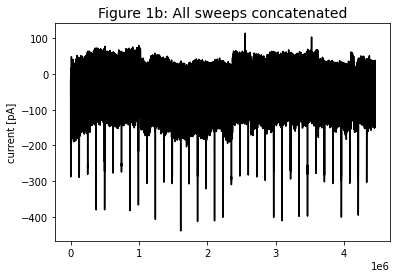

In [5]:
## Extract all sweeps
sweep_IB_1_tmp = np.array(channels_data_frame_1.loc['Channel B', :])
sweep_IB_1_concatenated = np.concatenate(sweep_IB_1_tmp)

# Plot it using tk if you want to zoom in to explore the trace
%matplotlib inline
plt.plot(sweep_IB_1_concatenated, 'k')
plt.title('Figure 1b: All sweeps concatenated', fontsize = 14)
plt.ylabel('current [pA]')
plt.show()

Plotting the concatenated sweeps is not very useful in such a small figure, but we can plot using TkAgg if we want to zoom in and inspect it more closely. What we can see is that the test_pulses seem to be of different sizes. However, if we zoom in we can see that it actually looks like that because there is a spike happening during the test_pulse. The test_pulses are actually quite stable, as we can see in the plot below.

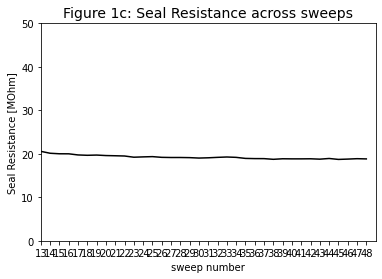

In [6]:
# Get Rseal data
Rseal_data_frame = getLooseRseal(file_name_1, channels_data_frame_1)
seal_resistance = Rseal_data_frame.loc['seal_resistance']

%matplotlib inline
plt.plot(seal_resistance, 'k')
plt.title('Figure 1c: Seal Resistance across sweeps', fontsize = 14)
plt.ylabel('Seal Resistance [MOhm]')
plt.xlabel('sweep number')
plt.axis([0, len(seal_resistance), 0, 50])
plt.show()

Now we are going to run `find_peaks` with different parameters and plot the histogram of the prominences of the detected peaks.

1080202


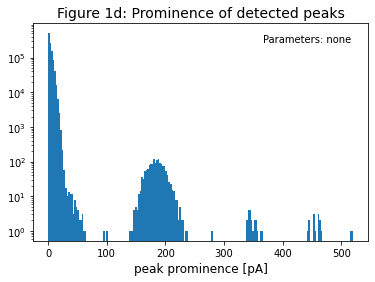

In [8]:
peaks_1a, properties_1a = find_peaks(-sweep_IB_1_concatenated, height = (None, None), threshold = (None, None), distance = None, prominence = (None, None), width = (None, None), wlen = None)
# Reverse the sign of the data to detect the lower peak of the spike (some are unipolar and only go down) and to avoid the noise.
print(len(peaks_1a))

%matplotlib inline
ax = plt.gca()
plt.hist(properties_1a['prominences'], bins = 200, density = False, histtype = 'bar', log = True)
plt.title('Figure 1d: Prominence of detected peaks', fontsize = 14)
plt.text(0.95, 0.95, 'Parameters: none')
plt.xlabel('peak promright [pA]', fontsize = 12)toph, transform = ax.transAxesow()

%matplotlib tk
plt.plot(peaks_1a, sweep_IB_1_concatenated[peaks_1a], "tk"); plt.plot(sweep_IB_1_concatenated); plt.legend(['peaks'])
plt.title('Figure 1d: Detected peaks for concatenated sweeps', fontsize = 14)
plt.xlabel('samples', fontsize = 12)
plt.ylabel('current [pA]', fontsize = 12)
plt.show()

1080202


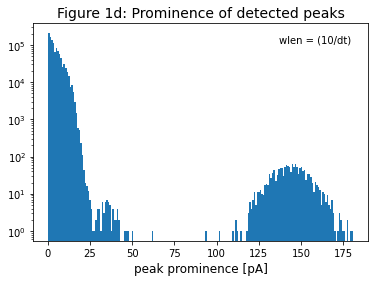

In [10]:
peaks_1b, properties_1b = find_peaks(-sweep_IB_1_concatenated, height = (None, None), threshold = (None, None), distance = None, prominence = (None, None), width = (None, None), wlen = (10/dt_1))
# Reverse the sign of the data to detect the lower peak of the spike (some are unipolar and only go down) and to avoid the noise.
print(len(peaks_1b))

%matplotlib inline
ax = plt.gca()
plt.hist(properties_1b['prominences'], bins = 200, density = False, histtype = 'bar', log = True)
plt.title('Figure 1d: Prominence of detected peaks', fontsize = 14)
plt.text(0.95, 0.95, 'wlen = (10/dt)', horizontalalignment='right', verticalalignment='top', transform = ax.transAxes)
plt.xlabel('peak prominence [pA]', fontsize = 12)
plt.show()

%matplotlib tk
plt.plot(peaks_1b, sweep_IB_1_concatenated[peaks_1b], "xr"); plt.plot(sweep_IB_1_concatenated); plt.legend(['peaks'])
plt.title('Figure 1d: Detected peaks for concatenated sweeps', fontsize = 14)
plt.xlabel('samples', fontsize = 12)
plt.ylabel('current [pA]', fontsize = 12)
plt.show()

1499


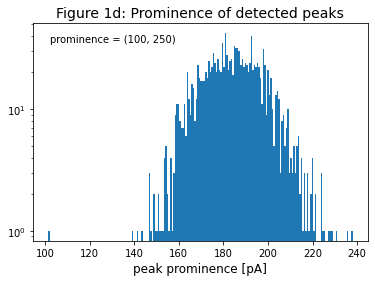

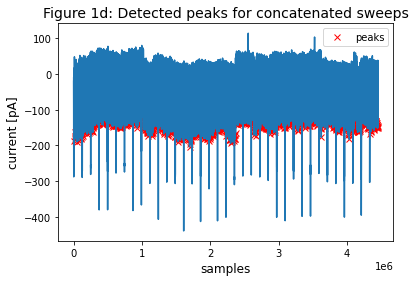

In [11]:
peaks_1c, properties_1c = find_peaks(-sweep_IB_1_concatenated, height = (None, None), threshold = (None, None), distance = None, prominence = (100, 250), width = (None, None), wlen = None)
# Reverse the sign of the data to detect the lower peak of the spike (some are unipolar and only go down) and to avoid the noise.
print(len(peaks_1c))

%matplotlib inline
ax = plt.gca()
plt.hist(properties_1c['prominences'], bins = 200, density = False, histtype = 'bar', log = True)
plt.title('Figure 1d: Prominence of detected peaks', fontsize = 14)
plt.text(0.05, 0.95, 'prominence = (100, 250)', fontsize = 10, horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
plt.xlabel('peak prominence [pA]', fontsize = 12)
plt.show()

%matplotlib inline
plt.plot(peaks_1c, sweep_IB_1_concatenated[peaks_1c], "xr"); plt.plot(sweep_IB_1_concatenated); plt.legend(['peaks'])
plt.title('Figure 1d: Detected peaks for concatenated sweeps', fontsize = 14)
plt.xlabel('samples', fontsize = 12)
plt.ylabel('current [pA]', fontsize = 12)
plt.show()

1514


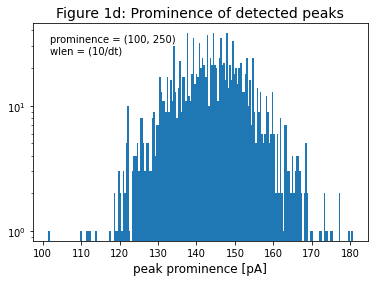

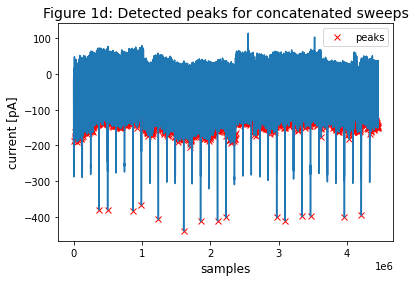

In [14]:
peaks_1d, properties_1d = find_peaks(-sweep_IB_1_concatenated, height = (None, None), threshold = (None, None), distance = None, prominence = (100, 250), width = (None, None), wlen = (10/dt_1))
# Reverse the sign of the data to detect the lower peak of the spike (some are unipolar and only go down) and to avoid the noise.
print(len(peaks_1d))

%matplotlib inline
ax = plt.gca()
plt.hist(properties_1d['prominences'], bins = 200, density = False, histtype = 'bar', log = True)
plt.title('Figure 1d: Prominence of detected peaks', fontsize = 14)
plt.text(0.05, 0.95, 'prominence = (100, 250)\nwlen = (10/dt)', fontsize = 10, horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes)
plt.xlabel('peak prominence [pA]', fontsize = 12)
plt.show()

%matplotlib inline
plt.plot(peaks_1d, sweep_IB_1_concatenated[peaks_1d], "xr"); plt.plot(sweep_IB_1_concatenated); plt.legend(['peaks'])
plt.title('Figure 1d: Detected peaks for concatenated sweeps', fontsize = 14)
plt.xlabel('samples', fontsize = 12)
plt.ylabel('current [pA]', fontsize = 12)
plt.show()

In [ ]:
%matplotlib inline

# Set colormap
cmap = plt.get_cmap('Pastel2')
noise_color = cmap(0)
spikes_color = cmap(1)

# Define region corresponding to spike size (pA)
spike_size_left_edge = 120
spike_size_right_edge = 240

n, bins, patches = plt.hist(properties_concatenaded['prominences'], bins = 200, density = False, histtype = 'bar', log = True)
# Use log = True to see the smaller peak in the histogram that corresponds to the spikes

for i in range(len(patches)):
    if (spike_size_left_edge < bins[i] < spike_size_right_edge):
        patches[i].set_facecolor(spikes_color)
    else:
        patches[i].set_facecolor(noise_color)

plt.title('Figure 4.4: Prominence of detected peaks', fontsize = 14)
plt.xlabel('peak prominence [pA]', fontsize = 12)
plt.show()

# Types of firing rate to assess

 * Instantaneous firing rate: inverse of the interspike interval

 * Firing rate over full recording

 * Firing rate over time windows (1s?)

### 1.2. | Find spikes on a sweep by sweep basis

Let's first remind ourselves of the data frame shape.


In [ ]:
# Load data
channels_data_frame, time, dt, folder_name, file_name = importFile(curated_channel = 'Sweeps_Analysis')
print("file imported")

In [ ]:
channels_data_frame

In [ ]:
# pandas.DataFrame.columns - The column labels of the DataFrame.
print(channels_data_frame.columns)

# pandas.DataFrame.index - The index (row labels) of the DataFrame.
print(channels_data_frame.index)

# pandas.DataFrame.iloc - integer-location based indexing for selection by position.
channels_data_frame.loc[['Channel A', 'Channel B'],:]

In [ ]:
for sweep in channels_data_frame.columns:
    sweep_IB = np.array(channels_data_frame.at['Channel B', sweep])

    peaks, properties = find_peaks(-sweep_IB,
                                   height = None,
                                   threshold = None,
                                   distance = 5,
                                   prominence = 50,
                                   width = 2,
                                   wlen = None,
                                   rel_height = None,
                                   plateau_size = None)
                                

In [ ]:
    cell_name = [file_name.split('.')[0]] # Get the file name without the extension
    print(cell_name)
    seal_resistance = []
    trial_keys = []

    for sweep in channels_data_frame.columns:
        
        sweep_IA = np.array(channels_data_frame.at['Channel A', sweep])
        sweep_IB = np.array(channels_data_frame.at['Channel B', sweep])
        sweep_OA = np.array(channels_data_frame.at['Output A', sweep])

        # Get the indices of the test_pulse using the Output Channel
        test_pulse = np.where(sweep_OA < 0)
        test_pulse_OA_indices = test_pulse[0]

        # # Find the edges of the test_pulse
        # test_pulse_start = np.where(np.diff(sweep_OA) < (0))
        # test_pulse_end = np.where(np.diff(sweep_OA) > (0))
        # # Extract them from the tuple
        # test_pulse_start_i = test_pulse_start[0][0]
        # test_pulse_end_i = test_pulse_end[0][0]

        # Use the indices of the test_pulse command to define baseline period and test period
        sweep_OA_baseline = np.mean(sweep_OA[:(test_pulse_OA_indices[0]-1)]) # -1 to stop baseline before command starts
        sweep_OA_pulse = np.mean(sweep_OA[test_pulse_OA_indices])
        test_pulse_command = sweep_OA_baseline - sweep_OA_pulse # mV

        # # Use the indices of the test_pulse command to define baseline period and test period
        # sweep_OA_baseline = np.mean(sweep_OA[int(test_pulse_start_i - (20/0.04)):test_pulse_start_i])
        # sweep_OA_pulse = np.mean(sweep_OA[int(test_pulse_end_i - (49/0.04)):test_pulse_end_i])
        # test_pulse_command = sweep_OA_baseline - sweep_OA_pulse #mV


        # Use the test_pulse indices to get the baseline and cell response to calculate the seal resistance
        # To be exact and account for the delays between digital command and output from the amplifier, you could add +1 to the first index to calculate the baseline.
        sweep_IB_baseline = np.mean(sweep_IB[:(test_pulse_OA_indices[0])])
        # Similary, to avoid using the values recorded while the test pulse command begins, you can skip a milisecond (+4 indices) to the beginning, to ensure you start averaging once the signal has reached the cell. To be extra exact, you could add +2 to the last index so you use all the samples. However, this shouldn't make a difference, so we just skip the milisecond to avoid the transition period.
        sweep_IB_pulse = np.mean(sweep_IB[(test_pulse_OA_indices[0]+4):(test_pulse_OA_indices[-1])])
        test_pulse_membrane = sweep_IB_baseline - sweep_IB_pulse # pA

        # # Do the same as above but for the Current channel
        # sweep_IB_baseline = np.mean(sweep_IB[int(test_pulse_start_i - (20/0.04)):test_pulse_start_i])
        # sweep_IB_pulse = np.mean(sweep_IB[int(test_pulse_end_i - (49/0.04)):test_pulse_end_i])
        # test_pulse_membrane = sweep_IB_baseline - sweep_IB_pulse #pA

        # Get seal resistance = mV/pA
        Rseal = (test_pulse_command / test_pulse_membrane) * 1000 # to get MOhm
        
        # append results
        seal_resistance.append(Rseal)
        trial_keys.append(sweep)

    # Create data frame of data:
    extracted_Rseal_data_frame = pd.DataFrame([seal_resistance], index = cell_name, columns = trial_keys)
